In [12]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, bin_data_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [24]:
#  Inputs config

input_fname_EWK = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fname_QCD = "../Data/SM_QCD_rivet_output.pickle"

load_model_EWK = ".EWK_density_model"
load_model_QCD = ".QCD_density_model"

load_whitening_funcs = ".whitening_funcs.pickle"

L             = 140e3    # integrated luminosity in /pb
max_n_gen_EWK = int(10000)
max_n_gen_QCD = int(20000)

In [14]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [5]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname_QCD}")
data_table_QCD = DataTable(input_fname_QCD)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_QCD.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_QCD.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_QCD.remove_column(observable)
print(" -- ordering observables")
data_table_QCD.reorder(*observables_order)
data_table_QCD.print_summary()

print(f"Creating EWK data table")
print(f" -- events from file {input_fname_EWK}")
data_table_EWK = DataTable(input_fname_EWK)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_EWK.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_EWK.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_EWK.remove_column(observable)
print(" -- ordering observables")
data_table_EWK.reorder(*observables_order)
data_table_EWK.print_summary()
    

Creating QCD data table
 -- events from file ../Data/SM_QCD_rivet_output.pickle
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 126626 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 126625 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 126625 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 123851 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 120416 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 120416 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 120416 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 120416 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 120409 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 120349 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 120349 events survived
 -- 

In [25]:

#data_table_QCD.xsec_per_event = 0.

sigma_EWK = data_table_EWK.xsec_per_event * data_table_EWK.get_sum_weights()
sigma_QCD = data_table_QCD.xsec_per_event * data_table_QCD.get_sum_weights()
sigma_tot = sigma_EWK+sigma_QCD


In [7]:

print(f"Loading whitening functions from file {load_whitening_funcs}")
whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))


Loading whitening functions from file .whitening_funcs.pickle


In [8]:
#  Load model if requested, otherwise build and fit
#

density_model_EWK = DensityModel.from_dir(load_model_EWK)
for m in density_model_EWK.likelihood_models :
    m.model.summary()

density_model_QCD = DensityModel.from_dir(load_model_QCD)
for m in density_model_QCD.likelihood_models :
    m.model.summary()


INFO       DensityModel.construct      Set model name           : dflt
INFO       DensityModel.construct      Set model num_gaussians  : 2
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 1
INFO       DensityModel.construct      Set observable types     : [<class 'float'>]
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 7)            14          input_2[0][0]                    
___________________________________

Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 7)            14          input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 7)            0           dense_46[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 30)           240         leaky_re_lu_28[0][0]             
______________________________________________________________________

In [26]:
import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K

ng = 15
sqrt_2pi = np.sqrt(2*np.pi)




def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    #x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
        
def K_dataset_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_get_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_likelihood (eval_p, params_p, ng)

def K_get_log_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, ng)

def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)



EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]

for model in EWK_models :
    model.name = model.name.replace("QCD", "EWK")
    for layer in model.layers :
        layer.name = layer.name.replace("QCD", "EWK")

condition_input_layer_cWtil = Input((1,), name="cWtil_input")
condition_input_layer_QCD   = Input((1,), name="QCD_input")
obs_input_layer             = Input((num_observables,), name="observable_input")

EWK_logL_layers, QCD_logL_layers = [], []

for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        cond_obs_split_layer = Lambda(lambda x : x[:, :i], name=f"split_observable_below{i}")(obs_input_layer)
        model_inputs_EWK.append(cond_obs_split_layer)
        model_inputs_QCD.append(cond_obs_split_layer)
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i], name=f"split_observable_eq{i}")(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood, name=f"EWK_logL_observable{i}")([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood, name=f"QCD_logL_observable{i}")([eval_p, QCD_params]))

# combine layers
EWK_logL = Lambda(lambda x : tf.add_n(x), name="EWK_logL_total")(EWK_logL_layers)
QCD_logL = Lambda(lambda x : tf.add_n(x), name="QCD_logL_total")(QCD_logL_layers)

QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

EWK_logL_model = Model([condition_input_layer_cWtil, obs_input_layer], EWK_logL)
EWK_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
QCD_precomputed_logL = Input((1,), name="QCD_logL_input")
QCD_precomputed_logL_reshaped = Lambda(lambda x : x[:,0], name="QCD_logL_input_reshaped")(QCD_precomputed_logL)
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_full")([EWK_logL, QCD_precomputed_logL_reshaped])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
dataset_logL_alt   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_partial")([EWK_logL, QCD_logL])
FullEvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, condition_input_layer_QCD, obs_input_layer],
                           outputs = dataset_logL_alt)
FullEvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 



Generating 10000 fake datapoints
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
10000 datapoints generated at cWtil=0 in 4s
QCD logL computed in 0.56s
EWK logL computed in 0.56s
sigma_gen_EWK = 0.071
sigma_gen_QCD = 0.000
sigma_EWK     = 0.290
sigma_QCD     = 0.000
sigma_tot     = 0.290
sigma_asimov  = 0.290
N_exp         = 40580.120
N_asimov      = 40580.1

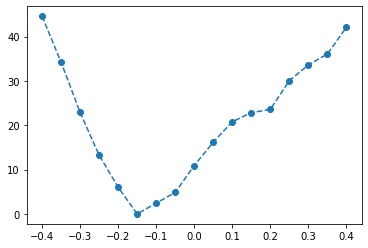

[44.58275924 34.2346577  22.88182497 13.2639888   6.0306472   0.
  2.43373286  4.83607209 10.91398    16.17045643 20.77871582 22.8332949
 23.57540641 30.05040176 33.58641357 36.07349081 42.07225676]
[2.43829401e-11 4.88511565e-09 1.72273129e-06 2.70553357e-04
 1.40595773e-02 1.00000000e+00 1.18749819e-01 2.78703069e-02
 9.54412523e-04 5.78899770e-05 5.15527304e-06 1.76678289e-06
 1.20112930e-06 4.20961308e-08 6.81672074e-09 1.90014282e-09
 8.79623041e-11]


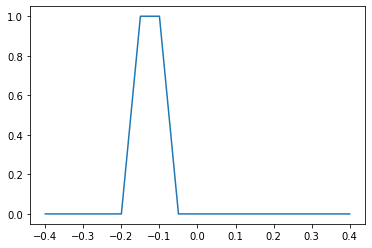

==========    0    -0.15000000000000002    ==========


/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1662: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


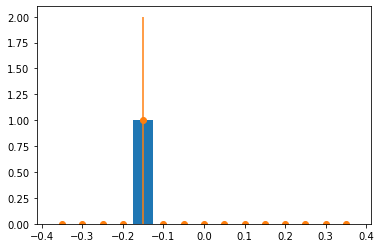

In [20]:
import scipy
from iminuit import Minuit
    
toy_fit_vals    = []
scans_record_L  = []
scans_record_CL = []

num_toys = 1

for toy_idx in range(num_toys) :

    #  Generate a large number of EWK datapoints at 0.
    #

    n_gen_EWK = int(np.min([max_n_gen_EWK, 4*sigma_EWK*L]))
    n_gen_QCD = int(np.min([max_n_gen_QCD, 4*sigma_QCD*L]))
    n_gen = n_gen_EWK + n_gen_QCD

    print(f"Generating {n_gen} fake datapoints")
    start = time.time()
    fake_white_datapoints_SM_EWK = density_model_EWK.sample(n_gen_EWK, [0])
    fake_white_datapoints_SM_QCD = density_model_QCD.sample(n_gen_QCD, [0])
    end = time.time()
    print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

    #  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

    start           = time.time()
    dummy_zeros_EWK = np.zeros(len(fake_white_datapoints_SM_EWK))
    dummy_zeros_QCD = np.zeros(len(fake_white_datapoints_SM_QCD))
    dummy_zeros     = np.concatenate([dummy_zeros_EWK, dummy_zeros_QCD])
    QCD_logL_EWK    = QCD_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
    QCD_logL_QCD    = QCD_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
    QCD_logL        = np.concatenate([QCD_logL_EWK, QCD_logL_QCD])
    QCD_L           = np.exp(QCD_logL)
    end             = time.time()
    print(f"QCD logL computed in {end-start:.2f}s")

    #  Compute logL_EWK here (to help with datapoint reweighting)

    start        = time.time()
    EWK_logL_EWK = EWK_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
    EWK_logL_QCD = EWK_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
    EWK_logL     = np.concatenate([EWK_logL_EWK, EWK_logL_QCD])
    EWK_L        = np.exp(EWK_logL)
    end          = time.time()
    print(f"EWK logL computed in {end-start:.2f}s")

    sigma_gen_EWK = n_gen_EWK / L
    sigma_gen_QCD = n_gen_QCD / L

    #fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * (sigma_EWK*EWK_L + sigma_QCD*QCD_L) / EWK_L
    fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * sigma_EWK * np.ones(len(fake_white_datapoints_SM_EWK)) 
    fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * sigma_QCD * np.ones(len(fake_white_datapoints_SM_QCD)) 
    fake_datapoint_weights     = np.concatenate([fake_datapoint_weights_EWK  , fake_datapoint_weights_QCD  ])
    fake_white_datapoints_SM   = np.concatenate([fake_white_datapoints_SM_EWK, fake_white_datapoints_SM_QCD])
    sum_weights = np.sum(fake_datapoint_weights)

    print(f"sigma_gen_EWK = {sigma_gen_EWK:.3f}")
    print(f"sigma_gen_QCD = {sigma_gen_QCD:.3f}")
    print(f"sigma_EWK     = {sigma_EWK:.3f}")
    print(f"sigma_QCD     = {sigma_QCD:.3f}")
    print(f"sigma_tot     = {sigma_tot:.3f}")
    print(f"sigma_asimov  = {sum_weights/L:.3f}")
    print(f"N_exp         = {sigma_tot*L:.3f}")
    print(f"N_asimov      = {sum_weights:.3f}")
    
    start   = time.time()
    SM_logL = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints_SM], verbose=0)
    end     = time.time()
    print(f"{end-start:.2f}s")
        
    ref_TNLL = -2 * np.sum (fake_datapoint_weights * SM_logL)
    
    def get_TNLL_plus_const (c) :
        global ref_TNLL
        cs = np.full(fill_value=c[0], shape=dummy_zeros.shape)
        TNLL  = -2 * np.sum (fake_datapoint_weights * EvaluatorModel.predict([cs, QCD_logL, fake_white_datapoints_SM], verbose=0))
        TNLL = TNLL - ref_TNLL
        return TNLL
    
    print("Doing scan")
    x = np.linspace(-0.4, 0.4, 17)
    y = []
    for xp in x :
        sys.stdout.write(f"\rDoing scan {xp:.3f} ********")
        yp = get_TNLL_plus_const([xp])
        y.append(yp)
    sys.stdout.write("\rScan complete ***************")
    y = y - np.min(y)
    plt.plot(x, y, "o--")
    plt.show()
    
    best_x, best_y = None, 1e30
    for xp, yp in zip(x, y) :
        if yp > best_y : continue
        best_x, best_y = xp, yp
    toy_fit_vals   .append(best_x)
    
    if np.fabs(best_x) < 0.4 :
        scans_record_L .append(y)
        scans_record_CL.append(1 - scipy.stats.chi2.cdf(y, 1))
        print(y)
        print(scans_record_CL[-1])
        plt.plot(x, [len([True for yp in scans_record_CL if yp[i]>0.05])/len(scans_record_CL) for i in range(len(x))])
        plt.show()

    print(f"==========    {toy_idx}    {best_x}    ==========")
    
    x = np.linspace(-.4, 0.4, 17)
    x = 0.5*(x[:-1] + x[1:])
    values, bins, _ = plt.hist(toy_fit_vals, bins=x)
    plt.errorbar(0.5*(bins[:-1]+bins[1:]), values, yerr=np.sqrt(values), fmt="o")
    plt.plot(x, (bins[1]-bins[0])*len(toy_fit_vals)*scipy.stats.norm.pdf(x, 0, np.std([xp for xp in toy_fit_vals if np.fabs(xp)<0.4])))
    plt.show()


In [264]:
'''start = time.time()
SM_logL = EvaluatorModel.evaluate([dummy_zeros, QCD_logL, fake_white_datapoints_SM], 
                              dummy_zeros,
                              sample_weight=fake_datapoint_weights,
                              verbose=0)
end = time.time()
print(f"{end-start:.2f}s")

ref_TNLL = -2 * sum_weights * SM_logL

x = np.linspace(-0.4, 0.4, 17)
y = []
for xp in x :
    yp = get_TNLL_plus_const([xp])
    y.append(yp)

#plt.plot(x, y-np.min(y), "o--")
#plt.show()

best_x, best_y = None, 1e30

for xp, yp in zip(x, y) :
    if yp > best_y : continue
    best_x, best_y = xp, yp
    
#print(best_x, best_y)
'''

'start = time.time()\nSM_logL = EvaluatorModel.evaluate([dummy_zeros, QCD_logL, fake_white_datapoints_SM], \n                              dummy_zeros,\n                              sample_weight=fake_datapoint_weights,\n                              verbose=0)\nend = time.time()\nprint(f"{end-start:.2f}s")\n\nref_TNLL = -2 * sum_weights * SM_logL\n\nx = np.linspace(-0.4, 0.4, 17)\ny = []\nfor xp in x :\n    yp = get_TNLL_plus_const([xp])\n    y.append(yp)\n\n#plt.plot(x, y-np.min(y), "o--")\n#plt.show()\n\nbest_x, best_y = None, 1e30\n\nfor xp, yp in zip(x, y) :\n    if yp > best_y : continue\n    best_x, best_y = xp, yp\n    \n#print(best_x, best_y)\n'

In [272]:

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, datapoints, weights=None, keys=None, cuts=[], save="", 
                             lims=True, bins=20, label=None, normed=None, as_lines=True, ebar=False, 
                             color="grey", lower=None, fill=True, log=False) :
        
    if type(weights) == type(None) :
        weights = np.ones(shape=(weights.shape[0],))
    filtered_datapoints, filtered_weights = datapoints, weights
    for cut in cuts :
        #print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_datapoints, filtered_weights = filter_data (filtered_datapoints, filtered_weights, keys, cut[0], cut[1], cut[2])
    
    if type(normed) == type(None) :
        filtered_weights = filtered_weights / np.sum(filtered_weights)
        normed = 1.
        
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = bin_data_1D(filtered_datapoints[:,obs_idx], bins, filtered_weights, as_lines=as_lines, normed=False)
    data_z = np.nan_to_num(data_z)
    data_z, data_ez = normed*data_z, normed*data_ez
    if type(lower) == type(None) : lower = np.zeros(shape=data_z.shape)
    if as_lines :
        if fill :
            ax.fill_between(data_x, lower, lower+data_z, alpha=0.3, color=color, linewidth=0.5)
            if log :
                ax.set_yscale("log")
                ax.set_ylim([1e-3, 10000])
        else :
            ax.plot(data_x, lower+data_z, "--", color=color, linewidth=1.)
    else :
        ax.errorbar(data_x, lower+data_z, yerr=data_ez, color=color, linewidth=0.5, fmt="o")
    ax.set_xlim([bins[0], bins[-1]])
    ax.axhline(0, linestyle="-" , c="grey", linewidth=2)
    #ax.set_yscale("log")
    return data_z, data_ez
            

In [273]:
print("Unwhitening fake datapoints")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened in {int(end-start):.0f}s")

Unwhitening fake datapoints
50000 datapoints unwhitened in 1s


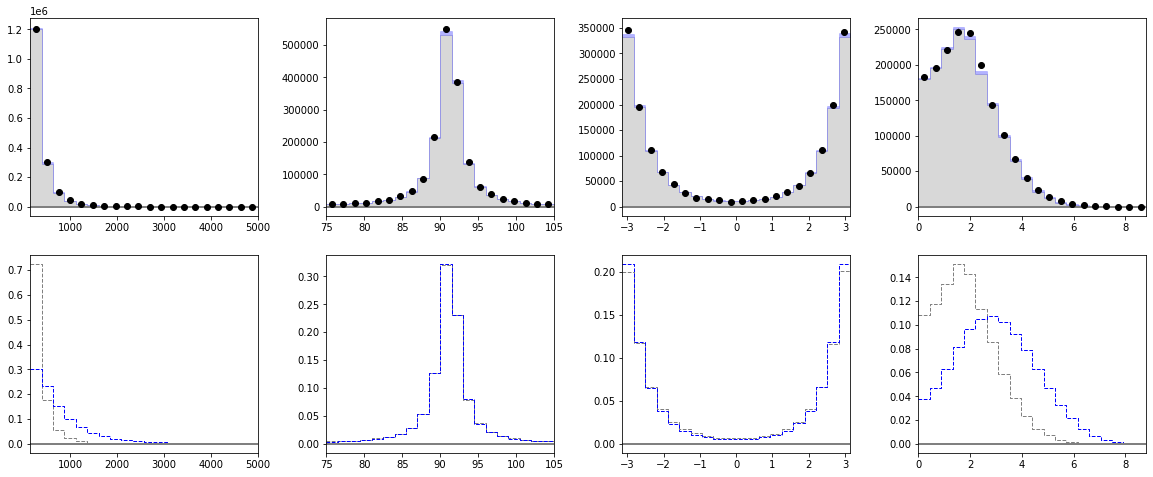

In [274]:

fig = plt.figure(figsize=(5*num_observables, 8))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(2, num_observables, 1+idx)
    observables_QCD, weights_QCD = data_table_QCD.get_observables_and_weights()
    observables_EWK, weights_EWK = data_table_EWK.get_observables_and_weights()
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, normed=data_table_QCD.xsec_per_event*L, ebar=False, color="grey")
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, normed=data_table_EWK.xsec_per_event*L, ebar=False, color="blue", lower=z_QCD)
    z_data, ez_data = plot_observable_on_axis (ax, obs, fake_datapoints_SM, fake_datapoint_weights, keys=data_table_EWK.keys, bins=20, normed=1., as_lines=False, ebar=True, color="black")
    
    ax = fig.add_subplot(2, num_observables, num_observables+1+idx)
    z_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, ebar=False, color="grey", fill=False)
    z_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, ebar=False, color="blue", fill=False)
plt.subplots_adjust(wspace=0.3)
plt.show()


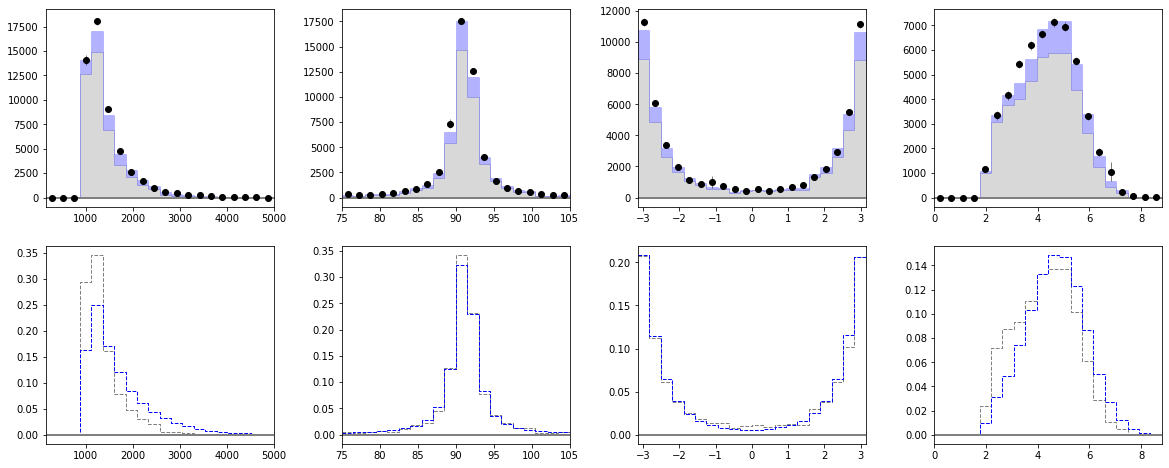

In [275]:

cuts = []
cuts.append(["m_jj"    , 1000, 5000])
cuts.append(["Dy_j_j"  , 2   , 8.8 ])


fig = plt.figure(figsize=(5*num_observables, 8))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(2, num_observables, 1+idx)
    observables_QCD, weights_QCD = data_table_QCD.get_observables_and_weights()
    observables_EWK, weights_EWK = data_table_EWK.get_observables_and_weights()
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, normed=data_table_QCD.xsec_per_event*L, ebar=False, color="grey", cuts=cuts)
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, normed=data_table_EWK.xsec_per_event*L, ebar=False, color="blue", lower=z_QCD, cuts=cuts)
    z_data, ez_data = plot_observable_on_axis (ax, obs, fake_datapoints_SM, fake_datapoint_weights, keys=data_table_EWK.keys, bins=20, normed=1., as_lines=False, ebar=True, color="black", cuts=cuts)
    
    '''z_den = [z_EWK[2*i] for i in range(len(z_data))]
    z_ref = [z_QCD[2*i] for i in range(len(z_data))]
    print(", ".join([f'{x:.2f}' for x in (z_data-z_ref)/z_den]))
    print(", ".join([f'{x:.2f}' for x in np.sqrt(z_data)/z_den]))'''
    #print(", ".join([f'{x:.2f}' for x in np.sqrt(z_EWK+z_QCD)/z_EWK]))
    
    ax = fig.add_subplot(2, num_observables, num_observables+1+idx)
    plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, ebar=False, color="grey", fill=False, cuts=cuts)
    plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, ebar=False, color="blue", fill=False, cuts=cuts)
plt.subplots_adjust(wspace=0.3)
plt.show()



Generating 4000 fake datapoints
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 2000 datapoints, observable index is 3
4000 datapoints generated at cWtil=0 in 2s
QCD logL computed in 0.24s
EWK logL computed in 0.24s
5.03s     -11965515.19846879    (density model and use numpy)
0.47s     -11967229.924594095    (logL model and use numpy)
0.46s     -1476679.1867471251    (FEM eval with weigh

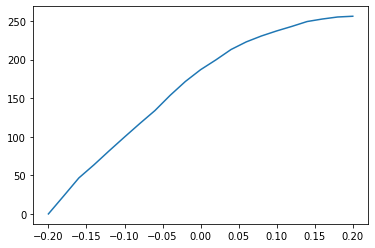

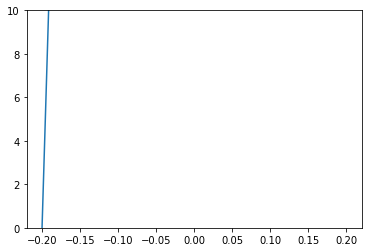

'\nds_full_logL     = FullEvaluatorModel.predict([test_zeros, test_zeros, fake_white_datapoints_SM], verbose=0)\nds_full_sig_logL = FullEvaluatorModel.predict([test_sig  , test_zeros, fake_white_datapoints_SM], verbose=0)\n\nfor obs in range(4) :\n    w1 = fake_datapoint_weights\n    w2 = fake_datapoint_weights * np.exp(ds_full_sig_logL-ds_full_logL)\n    vals1, bins1 = np.histogram(ds_real[:,obs], weights=w1)\n    vals2, _     = np.histogram(ds_real[:,obs], weights=w2   , bins=bins1)\n    fe1, fe2     = 1 / np.sqrt(vals1), 1 / np.sqrt(vals2)\n    f            = vals2 / vals1\n    \n    plt.errorbar(0.5*(bins1[1:]+bins1[:-1]), f, yerr=f*fe2)\n    plt.gca()\n    plt.show()'

In [163]:
'''dphi_j_j = np.linspace(-5, 5, 31)
m_jj     = np.full(fill_value=0.1  , shape=dphi_j_j.shape)
m_ll     = np.full(fill_value=0.1  , shape=dphi_j_j.shape)
dy_j_j   = np.full(fill_value=0.6  , shape=dphi_j_j.shape)
test_zeros = np.zeros(shape=dphi_j_j.shape)
test_sig   = np.ones(shape=dphi_j_j.shape) * 0.4

ds = np.array([m_jj, m_ll, dphi_j_j, dy_j_j]).transpose()
ds_full_sig_logL = FullEvaluatorModel.predict([test_sig, test_zeros, ds], verbose=0)

ds_QCD_logL  = QCD_logL_model.predict([test_zeros, ds], verbose=0)
ds_full_logL = FullEvaluatorModel.predict([test_zeros, test_zeros, ds], verbose=0)

plt.plot(ds_real[:,2], np.exp(ds_QCD_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_full_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_full_sig_logL)/np.exp(ds_full_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_EWK_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_EWK_sig_logL)/np.exp(ds_EWK_logL))
plt.show()'''



#  Generate a large number of EWK datapoints at 0.
#

max_n_gen_EWK = int(2000)
max_n_gen_QCD = int(2000)

n_gen_EWK = int(np.min([max_n_gen_EWK, sigma_EWK*L]))
n_gen_QCD = int(np.min([max_n_gen_QCD, sigma_QCD*L]))
n_gen = n_gen_EWK + n_gen_QCD

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints_SM_EWK = density_model_EWK.sample(n_gen_EWK, [0])
fake_white_datapoints_SM_QCD = density_model_QCD.sample(n_gen_QCD, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start           = time.time()
dummy_zeros_EWK = np.zeros(len(fake_white_datapoints_SM_EWK))
dummy_zeros_QCD = np.zeros(len(fake_white_datapoints_SM_QCD))
dummy_zeros     = np.concatenate([dummy_zeros_EWK, dummy_zeros_QCD])
QCD_logL_EWK    = QCD_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
QCD_logL_QCD    = QCD_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
QCD_logL        = np.concatenate([QCD_logL_EWK, QCD_logL_QCD])
end             = time.time()
print(f"QCD logL computed in {end-start:.2f}s")

#  Compute logL_EWK here (to help with datapoint reweighting)

start        = time.time()
EWK_logL_EWK = EWK_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
EWK_logL_QCD = EWK_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
EWK_logL     = np.concatenate([EWK_logL_EWK, EWK_logL_QCD])
end          = time.time()
print(f"EWK logL computed in {end-start:.2f}s")

#  Get datapoint likelihoods at 0 hypothesis
#

QCD_L_EWK = np.exp(QCD_logL_EWK)
QCD_L_QCD = np.exp(QCD_logL_QCD)
EWK_L_EWK = np.exp(EWK_logL_EWK)
EWK_L_QCD = np.exp(EWK_logL_QCD)

sigma_gen_EWK = n_gen_EWK / L
sigma_gen_QCD = n_gen_QCD / L

fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * sigma_EWK * np.ones(len(fake_white_datapoints_SM_EWK)) # * (sigma_EWK + (sigma_QCD*QCD_L_EWK/EWK_L_EWK))
fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * sigma_QCD * np.ones(len(fake_white_datapoints_SM_QCD)) # * (sigma_QCD + (sigma_EWK*EWK_L_QCD/QCD_L_QCD))

fake_datapoint_weights   = np.concatenate([fake_datapoint_weights_EWK  , fake_datapoint_weights_QCD  ])
fake_white_datapoints_SM = np.concatenate([fake_white_datapoints_SM_EWK, fake_white_datapoints_SM_QCD])

sum_weights = np.sum(fake_datapoint_weights)
    
test_zeros = np.zeros(shape=(len(fake_white_datapoints_SM),))
test_sig   = np.ones (shape=(len(fake_white_datapoints_SM),)) * 0.4


start         = time.time()
QCD_L_test    = density_model_QCD.evaluate(0, fake_white_datapoints_SM)
EWK_L_test    = density_model_EWK.evaluate(0, fake_white_datapoints_SM)
comb_test     = np.log((sigma_QCD*QCD_L_test + sigma_EWK*EWK_L_test) / sigma_tot)
comb_test     = np.sum(fake_datapoint_weights*comb_test)
end           = time.time()
print(f"{end-start:.2f}s     {comb_test}    (density model and use numpy)")

start         = time.time()
QCD_logL_test = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)
EWK_logL_test = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)
comb_test     = np.log((sigma_QCD*np.exp(QCD_logL_test) + sigma_EWK*np.exp(EWK_logL_test)) / sigma_tot)
comb_test     = np.sum(fake_datapoint_weights*comb_test)
end           = time.time()
print(f"{end-start:.2f}s     {comb_test}    (logL model and use numpy)")

start         = time.time()
full_test     = FullEvaluatorModel.evaluate([test_zeros, test_zeros, fake_white_datapoints_SM], test_zeros, sample_weight=fake_datapoint_weights, verbose=0)
full_test     = sum_weights * full_test / n_gen
end           = time.time()
print(f"{end-start:.2f}s     {full_test}    (FEM eval with weights)")

start         = time.time()
full_test2    = EvaluatorModel.evaluate([test_zeros, QCD_logL_test, fake_white_datapoints_SM], test_zeros, sample_weight=fake_datapoint_weights, verbose=0)
full_test2    = sum_weights * full_test2 / n_gen
end           = time.time()
print(f"{end-start:.2f}s     {full_test2}    (EM eval with weights)")

start         = time.time()
full_test4    = FullEvaluatorModel.predict([test_zeros, test_zeros, fake_white_datapoints_SM], verbose=0)
full_test4    = np.sum(fake_datapoint_weights*full_test4)
end           = time.time()
print(f"{end-start:.2f}s     {full_test4}    (FEM eval then weight)")

start         = time.time()
full_test3    = EvaluatorModel.predict([test_zeros, QCD_logL_test, fake_white_datapoints_SM], verbose=0)
full_test3    = np.sum(fake_datapoint_weights*full_test3)
end           = time.time()
print(f"{end-start:.2f}s     {full_test3}    (EM eval then weight)")



ds_real = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)

QCD_logL = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)

x, y = [], []
for i in np.linspace(-0.2, 0.2, 21) :
    sys.stdout.write(f"\r{i}  *************************")
    test_sig = np.ones (shape=(len(fake_white_datapoints_SM),)) * i
    
    yp = EvaluatorModel.predict([test_sig, QCD_logL_test, fake_white_datapoints_SM], verbose=0)
    
    x.append(i)
    y.append(-2*np.sum(fake_datapoint_weights*yp)) 
plt.plot(x, y - np.min(y))
plt.show()
plt.plot(x, y - np.min(y))
plt.gca().set_ylim([0, 10])
plt.show()

'''
ds_full_logL     = FullEvaluatorModel.predict([test_zeros, test_zeros, fake_white_datapoints_SM], verbose=0)
ds_full_sig_logL = FullEvaluatorModel.predict([test_sig  , test_zeros, fake_white_datapoints_SM], verbose=0)

for obs in range(4) :
    w1 = fake_datapoint_weights
    w2 = fake_datapoint_weights * np.exp(ds_full_sig_logL-ds_full_logL)
    vals1, bins1 = np.histogram(ds_real[:,obs], weights=w1)
    vals2, _     = np.histogram(ds_real[:,obs], weights=w2   , bins=bins1)
    fe1, fe2     = 1 / np.sqrt(vals1), 1 / np.sqrt(vals2)
    f            = vals2 / vals1
    
    plt.errorbar(0.5*(bins1[1:]+bins1[:-1]), f, yerr=f*fe2)
    plt.gca()
    plt.show()'''


Generating 100000 fake datapoints
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 datapoints generated at cWtil=0 in 46s
QCD logL computed in 5.53s
EWK logL computed in 5.53s
0.4  *******************************************

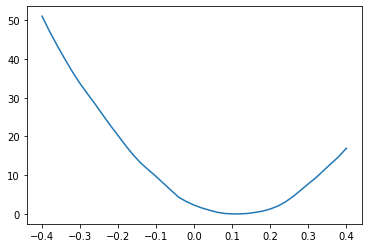

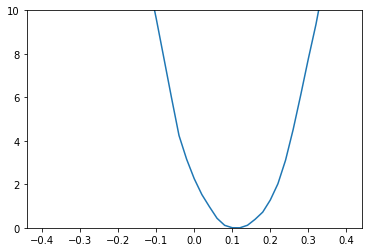

In [253]:
#  Generate a large number of EWK datapoints at 0.
#
L     = 140e3
n_gen = int(100000)

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints = density_model_EWK.sample(n_gen, [0])
print(f"{n_gen} datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")

#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start       = time.time()
dummy_zeros = np.zeros(len(fake_white_datapoints))
QCD_logL    = QCD_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
QCD_L       = np.exp(QCD_logL)
print(f"QCD logL computed in {time.time()-start:.2f}s")

#  Compute logL_EWK here (to help with datapoint reweighting)

start    = time.time()
EWK_logL = EWK_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
EWK_L    = np.exp(EWK_logL)
print(f"EWK logL computed in {time.time()-start:.2f}s")

#  Get datapoint likelihoods at 0 hypothesis
#

fake_datapoint_weights = (L / n_gen) * (sigma_EWK + (sigma_QCD*QCD_L/EWK_L))
sum_weights            = np.sum(fake_datapoint_weights)

yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))
TNLL_NULL = np.sum(np.longdouble(fake_datapoint_weights)*yp_NULL)

x, y = [], []
for i in np.linspace(-0.4, 0.4, 41) :
    sys.stdout.write(f"\r{i}  *************************")
    test_sig = np.ones (shape=(len(fake_white_datapoints),)) * i
    
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
    TNLL = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL)) + TNLL_NULL)
    
    x.append(i)
    y.append(TNLL) 
    
plt.plot(x, y - np.min(y))
plt.show()

plt.plot(x, y - np.min(y))
plt.gca().set_ylim([0, 10])
plt.show()


0.2  ******************************************

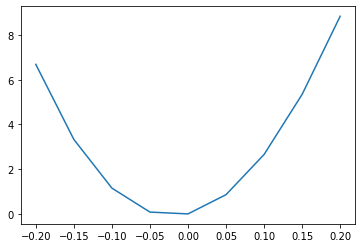

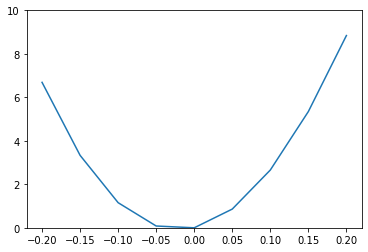

In [250]:
x, y = [], []
for i in np.linspace(-0.2, 0.2, 9) :
    sys.stdout.write(f"\r{i}  *************************")
    test_sig = np.ones (shape=(len(fake_white_datapoints),)) * i
    
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
    TNLL = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL)) + TNLL_NULL)
    
    x.append(i)
    y.append(TNLL) 
    
plt.plot(x, y - np.min(y))
plt.show()

plt.plot(x, y - np.min(y))
plt.gca().set_ylim([0, 10])
plt.show()

In [232]:
'''
test_sig = np.ones (len(fake_white_datapoints))
yp0  = EvaluatorModel.predict([test_sig*0.000000, QCD_logL, fake_white_datapoints], verbose=0)
yp1  = EvaluatorModel.predict([test_sig*0.000090, QCD_logL, fake_white_datapoints], verbose=0)
yp2  = EvaluatorModel.predict([test_sig*0.000100, QCD_logL, fake_white_datapoints], verbose=0)

for i, (y0p, y1p, y2p, wp) in enumerate(zip(yp0, yp1, yp2, fake_datapoint_weights)) :
    print(i, y0p, y1p, wp, wp*(y0p-y1p))
    
print(np.sum(fake_datapoint_weights*yp1) - np.sum(fake_datapoint_weights*yp0))
print(fake_datapoint_weights*(yp1-yp0))
print(fake_datapoint_weights*yp0)
print(fake_datapoint_weights*yp1)
print(np.sum(fake_datapoint_weights*(yp1-yp0)))
print(np.sum(fake_datapoint_weights*yp0))
print(np.sum(fake_datapoint_weights*yp1))'''

'\ntest_sig = np.ones (len(fake_white_datapoints))\nyp0  = EvaluatorModel.predict([test_sig*0.000000, QCD_logL, fake_white_datapoints], verbose=0)\nyp1  = EvaluatorModel.predict([test_sig*0.000090, QCD_logL, fake_white_datapoints], verbose=0)\nyp2  = EvaluatorModel.predict([test_sig*0.000100, QCD_logL, fake_white_datapoints], verbose=0)\n\nfor i, (y0p, y1p, y2p, wp) in enumerate(zip(yp0, yp1, yp2, fake_datapoint_weights)) :\n    print(i, y0p, y1p, wp, wp*(y0p-y1p))\n    \nprint(np.sum(fake_datapoint_weights*yp1) - np.sum(fake_datapoint_weights*yp0))\nprint(fake_datapoint_weights*(yp1-yp0))\nprint(fake_datapoint_weights*yp0)\nprint(fake_datapoint_weights*yp1)\nprint(np.sum(fake_datapoint_weights*(yp1-yp0)))\nprint(np.sum(fake_datapoint_weights*yp0))\nprint(np.sum(fake_datapoint_weights*yp1))'

In [248]:
'''
variational_mean, variational_width = -0.08, -3

def variational_logpdf (x, m, w) :
    return scipy.stats.norm.logpdf(x, m, w)

logL = {}
dp_logL_NULL = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))
logL_NULL    = np.sum(np.longdouble(fake_datapoint_weights)*dp_logL_NULL)
def ELBO (m, w, n=10, lower=-0.4, upper=0.4) :
    w = np.exp(w)
    def integrand (theta) :
        if type(theta) in [list, np.ndarray] :
            return [integrand(tp) for tp in theta]
        if theta not in logL :
            test_sig     = np.ones (shape=(len(fake_white_datapoints),)) * theta
            dp_logL      = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
            logL [theta] = np.sum ( np.longdouble(fake_datapoint_weights) * (dp_logL-dp_logL_NULL) ) #+ logL_NULL
        logq = variational_logpdf(theta, m, w)
        return np.exp(logq) * (logL [theta] - logq)
    ret = scipy.integrate.fixed_quad(integrand, lower, upper, n=n)[0]
    print(f"{m:.2}".ljust(10), f"{w:.2f}".ljust(10), f"{ret}")
    return ret

fit_ELBO = lambda p : - ELBO (p[0], p[1], n=20)

m = Minuit.from_array_func(fit_ELBO, [variational_mean, variational_width], [0.5, 0.5], errordef=1)
m.migrad()

print(m.values[0], np.exp(m.values[1]))'''

'\nvariational_mean, variational_width = -0.08, -3\n\ndef variational_logpdf (x, m, w) :\n    return scipy.stats.norm.logpdf(x, m, w)\n\nlogL = {}\ndp_logL_NULL = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))\nlogL_NULL    = np.sum(np.longdouble(fake_datapoint_weights)*dp_logL_NULL)\ndef ELBO (m, w, n=10, lower=-0.4, upper=0.4) :\n    w = np.exp(w)\n    def integrand (theta) :\n        if type(theta) in [list, np.ndarray] :\n            return [integrand(tp) for tp in theta]\n        if theta not in logL :\n            test_sig     = np.ones (shape=(len(fake_white_datapoints),)) * theta\n            dp_logL      = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))\n            logL [theta] = np.sum ( np.longdouble(fake_datapoint_weights) * (dp_logL-dp_logL_NULL) ) #+ logL_NULL\n        logq = variational_logpdf(theta, m, w)\n        return np.exp(logq) * (logL [theta] - logq)\n    ret = scipy.

In [283]:
#  Generate a large number of EWK datapoints at 0.
#
n_gen_EWK = int(5000)
n_gen_QCD = int(0)
n_gen = n_gen_EWK + n_gen_QCD

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints_EWK = density_model_EWK.sample(n_gen_EWK, [0])
fake_white_datapoints_QCD = density_model_QCD.sample(n_gen_QCD, [0])
fake_white_datapoints     = np.concatenate([fake_white_datapoints_EWK, fake_white_datapoints_QCD])
print(f"{n_gen} datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")

#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start       = time.time()
dummy_zeros = np.zeros(len(fake_white_datapoints))
QCD_logL    = QCD_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
print(f"QCD logL computed in {time.time()-start:.2f}s")

#  Compute logL_EWK here (to help with datapoint reweighting)

start    = time.time()
EWK_logL = EWK_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
print(f"EWK logL computed in {time.time()-start:.2f}s")

#  Get datapoint likelihoods at 0 hypothesis
#

start    = time.time()
logL_NULL = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL    = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")


Generating 5000 fake datapoints
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
5000 datapoints generated at cWtil=0 in 2s
QCD logL computed in 0.29s
EWK logL computed in 0.28s
SM logL computed in 0.29s


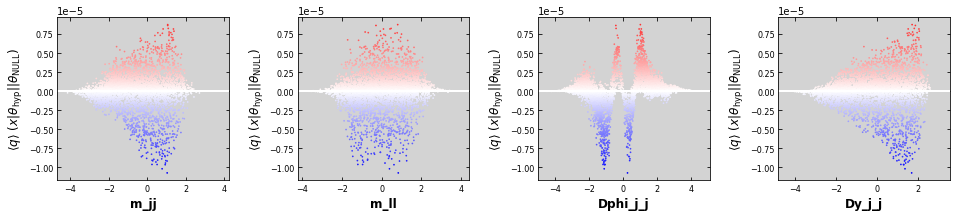

In [297]:

x, y = [], []
for theta in [0.1] :
    test_sig = np.full (fill_value=theta, shape=(len(fake_white_datapoints),))
    logL     = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
    z        = -2 * L_NULL * (logL - logL_NULL)
    z_max    = np.max(np.fabs(z))
    
    fig = plt.figure(figsize=(4*num_observables, 3))
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        ax = fig.add_subplot(1, num_observables, row_idx + 1)
        ax.scatter(x, z, s=0.5, c=z, cmap="bwr", vmin=-z_max, vmax=z_max)
        ax.set_facecolor("lightgrey")
        ax.axhline(0, c="white", linewidth=2)
        ax.set_ylabel(r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=12, weight="bold")
        ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
        ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

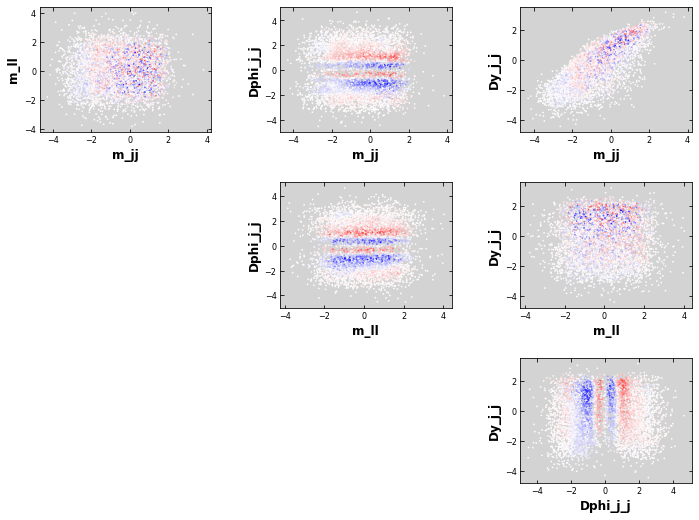

In [300]:

x, y = [], []
for theta in [0.1] : # np.linspace(-0.4, 0.4, 41) :
    test_sig = np.full (fill_value=theta, shape=(len(fake_white_datapoints),))
    logL     = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
    z        = -2 * L_NULL * (logL - logL_NULL)
    z_max    = np.max(np.fabs(z))
    
    fig = plt.figure(figsize=(4*num_observables, 3*num_observables))
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        for col_idx in range(row_idx+1, num_observables) :
            ax = fig.add_subplot(num_observables, num_observables, num_observables*row_idx + col_idx + 1)
            if row_idx == col_idx :
                ax.scatter(x, z, s=0.5, c=z, cmap="bwr", vmin=-z_max, vmax=z_max)
                ax.set_facecolor("lightgrey")
                ax.axhline(0, c="white", linewidth=2)
                ax.set_ylabel(r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=12, weight="bold")
            else :
                y = fake_white_datapoints[:,col_idx]
                ax.scatter(x, y, s=0.5, c=z, cmap="bwr", vmin=-z_max, vmax=z_max)
                ax.set_facecolor("lightgrey")
                ax.set_ylabel(observables_order[col_idx], fontsize=12, weight="bold")
            ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
            ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

In [163]:
from keras import backend as K

print("here 1")
logL_gradient  = K.gradients(FullEvaluatorModel.outputs, FullEvaluatorModel.inputs)

print("here 2")
logL_grad_func = K.function (FullEvaluatorModel.inputs, logL_gradient)

print("here 3")
logL_grads_SM = logL_grad_func([dummy_zeros.reshape((len(dummy_zeros),1))+best_x, 
                                dummy_zeros.reshape((len(dummy_zeros),1)),
                                fake_white_datapoints_SM])

print("here 4")
logL_grad_wrt_x_SM = np.array(logL_grads_SM[2])

print("here 5")
logL_SM = FullEvaluatorModel.predict([dummy_zeros.reshape((len(dummy_zeros),1))+best_x, 
                                      dummy_zeros.reshape((len(dummy_zeros),1)),
                                      fake_white_datapoints_SM])

print("here 6")



here 1
here 2
here 3
here 4
here 5
here 6


In [164]:

print("here 3")
logL_grads_alt = logL_grad_func([dummy_zeros.reshape((len(dummy_zeros),1))+best_x+0.1, 
                                 dummy_zeros.reshape((len(dummy_zeros),1)),
                                 fake_white_datapoints_SM])

print("here 4")
logL_grad_wrt_x_alt = np.array(logL_grads_alt[2])

print("here 5")
logL_alt = FullEvaluatorModel.predict([dummy_zeros.reshape((len(dummy_zeros),1))+best_x+0.1,
                                       dummy_zeros.reshape((len(dummy_zeros),1)),
                                       fake_white_datapoints_SM])

print("here 6")

here 3
here 4
here 5
here 6


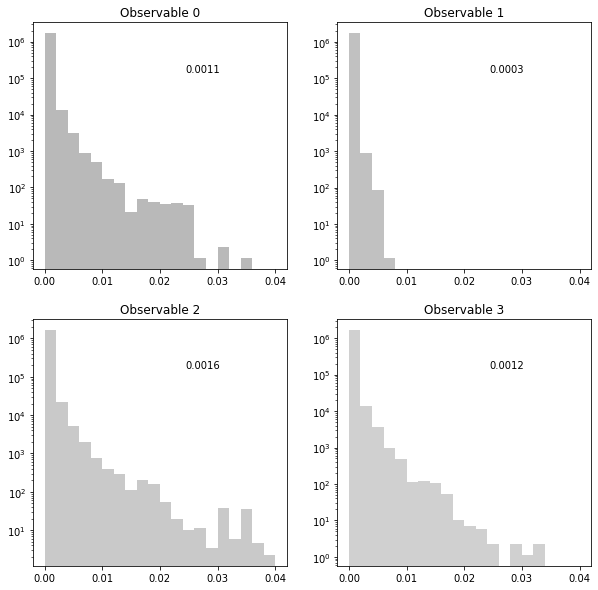

In [165]:
fig = plt.figure(figsize=(10, 10))

for i in range(num_observables) :
    ax = fig.add_subplot(2, 2, i+1)

    TNLL_grad = -2. * ((logL_grad_wrt_x_alt[:,i]/logL_alt) - (logL_grad_wrt_x_SM[:,i]/logL_SM))
    ax.hist(np.fabs(TNLL_grad), bins=np.linspace(0, 0.04, 21), weights=fake_datapoint_weights, color=f"{0.1+0.1*i}", alpha=0.3)
    ax.text(0.6, 0.8, f"{np.std(np.fabs(TNLL_grad)):.4f}", transform=plt.gca().transAxes)

    ax.set_yscale("log")
    ax.set_title(f"Observable {i}")

plt.show()
    

In [ ]:
'''print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              verbose=0))

print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              sample_weight=np.full(fill_value=1, shape=dummy_zeros.shape),
                              verbose=0))

print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              sample_weight=np.full(fill_value=2, shape=dummy_zeros.shape),
                              verbose=0))'''

In [ ]:
'''Ls = density_model_QCD.evaluate(0, fake_white_datapoints_SM)
print(np.sum(np.log(Ls)), np.mean(np.log(Ls)))'''

In [ ]:
'''print(QCD_models[0].evaluate(np.zeros(len(fake_datapoint_weights)), 
                       fake_white_datapoints_SM[:,0]))

print(QCD_models[1].evaluate([np.zeros(len(fake_datapoint_weights)), fake_white_datapoints_SM[:,:1]], 
                       fake_white_datapoints_SM[:,1]))

2.3675751178472604 + 1.6618719752872442'''

In [ ]:
'''from iminuit import Minuit

def model_get_NLL (self, params, dataset, weights=None) :
    num_observables = dataset.shape[1]
    params          = np.full(fill_value=params, shape=dataset[:,0].shape)
    NLL             = self.likelihood_models[0].model.evaluate(params, dataset[:,0], sample_weight=weights, verbose=0)
    for obs_idx in range(1, num_observables) :
        NLL = NLL + self.likelihood_models[obs_idx].model.evaluate([params, dataset[:,:obs_idx]], dataset[:,0], sample_weight=weights, verbose=0)
    return NLL

print("Calculating constants")
C_QCD   = sigma_QCD * np.exp(-fake_datapoint_weights*density_model_QCD.evaluate(0, fake_white_datapoints_SM))
C_SM    = C_QCD + sigma_EWK * np.exp(-fake_datapoint_weights*density_model_EWK.evaluate(0, fake_white_datapoints_SM))
TNLL_SM = np.sum(-2 * np.log(C_SM))

def get_TNLL_plus_const (c) :
    c = c[0]
    C_EWK = sigma_EWK * np.exp(-fake_datapoint_weights*density_model_EWK.evaluate(c, fake_white_datapoints_SM))
    TNLL  = -2 * np.log(C_QCD + C_EWK)
    TNLL  = np.sum(TNLL) - TNLL_SM
    print(c, TNLL)
    return TNLL

print("Fitting")
m = Minuit.from_array_func(get_TNLL_plus_const, [0,], [1.,], errordef=1.)
m.migrad(precision=0.02)
'''

In [ ]:
'''import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K

ng = 15
sqrt_2pi = np.sqrt(2*np.pi)




def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    #x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
        
def K_dataset_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_get_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_likelihood (eval_p, params_p, ng)

def K_get_log_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, ng)

def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)



EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]

for model in EWK_models :
    model.name = model.name.replace("QCD", "EWK")
    for layer in model.layers :
        layer.name = layer.name.replace("QCD", "EWK")

condition_input_layer_cWtil = Input((1,))
condition_input_layer_QCD   = Input((1,))
obs_input_layer             = Input((num_observables,))

EWK_logL_layers, QCD_logL_layers = [], []

for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        model_inputs_EWK.append(Lambda(lambda x : x[:, :i])(obs_input_layer))
        model_inputs_QCD.append(Lambda(lambda x : x[:, :i])(obs_input_layer))
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i])(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood)([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood)([eval_p, QCD_params]))

# combine layers
combine_layers = Lambda(lambda x : tf.add_n(x))
EWK_logL = combine_layers(EWK_logL_layers)
QCD_logL = combine_layers(QCD_logL_layers)

QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
QCD_precomputed_logL = Input((1,))
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods)([EWK_logL, QCD_precomputed_logL])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 
'''

In [ ]:
'''#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start       = time.time()
dummy_zeros = np.zeros(shape=fake_datapoint_weights.shape)
QCD_logL    = QCD_logL_model.predict([dummy_zeros, fake_white_datapoints_SM], verbose=0)
end         = time.time()
print(f"QCD logL computed in {end-start:.2f}s")
'''